# Problem Statement
This project aims to detect signs of tuberculosis (TB) in chest X-ray images using classical digital image processing techniques. We implement a full image processing pipeline—from preprocessing to feature extraction and analysis—to highlight the effectiveness of each step.

## Preprocessing Pipeline

### Modules

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import random



### Preprocessing

#### CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [2]:
def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

#### Gaussian Blur

In [3]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = apply_clahe(img)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img



## Image Processing & Transformation

### Otsu Thresholding + Morphological Cleaning

In [4]:
def segment_mask(img):
    try:
        t = threshold_otsu(img)
        mask = img > t
        mask = remove_small_objects(mask, min_size=500)
        mask = closing(mask, disk(5))
        return mask
    except:
        return None


### Labeling & Region Properties

In [5]:
def extract_features(mask, img):
    labeled = label(mask)
    regions = regionprops(labeled, intensity_image=img)
    if not regions:
        return None
    r = max(regions, key=lambda x: x.area)
    minr, minc, maxr, maxc = r.bbox
    cropped = img[minr:maxr, minc:maxc]
    cropped = cv2.resize(cropped, (64, 64))
    cropped = np.uint8(cropped / np.max(cropped) * 255)

    glcm = graycomatrix(cropped, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return {
        'area': r.area,
        'perimeter': r.perimeter,
        'eccentricity': r.eccentricity,
        'mean_intensity': r.mean_intensity,
        'solidity': r.solidity,
        'glcm_contrast': graycoprops(glcm, 'contrast')[0, 0],
        'glcm_homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'glcm_energy': graycoprops(glcm, 'energy')[0, 0],
        'glcm_correlation': graycoprops(glcm, 'correlation')[0, 0],
    }


## Analysis & Feature Extraction

634it [00:36, 14.93it/s]

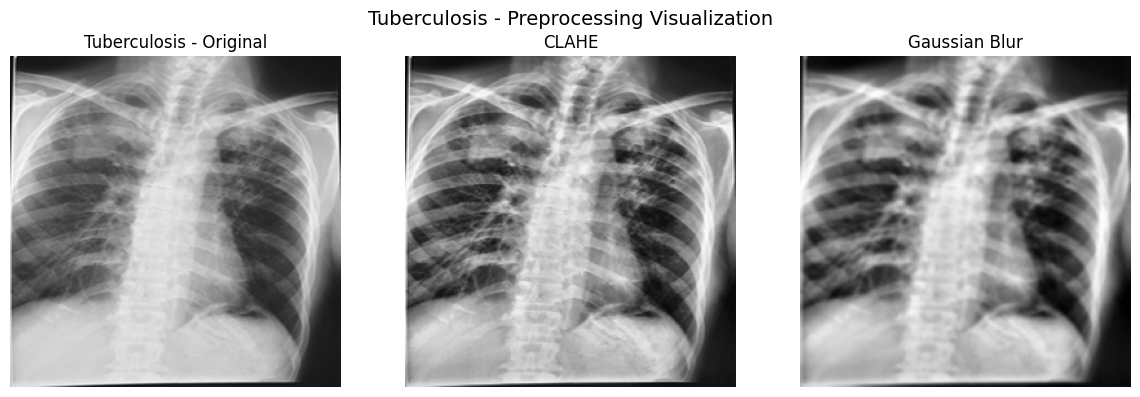

700it [00:41, 16.79it/s]
2235it [00:31, 65.79it/s]

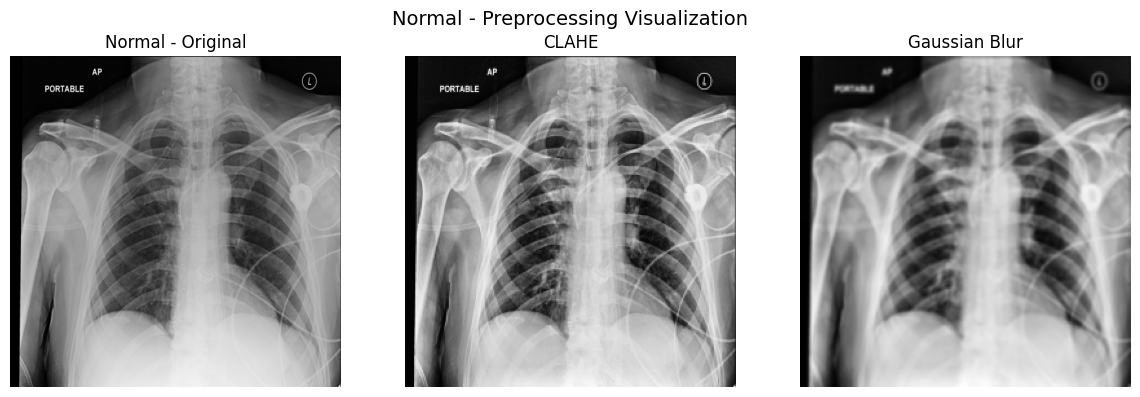

3500it [00:51, 67.43it/s]


In [6]:
data_dir = Path('../data/TB_Chest_Radiography_Database/')
classes = ['Tuberculosis', 'Normal']
features = []

visual_samples = {
    cls: random.choice(list((data_dir / cls).iterdir()))
    for cls in classes
}

for cls in classes:
    class_dir = data_dir / cls
    for fname in tqdm(class_dir.iterdir()):        
        img = preprocess_image(fname)

        if fname == visual_samples[cls]:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.imread(fname, cv2.IMREAD_GRAYSCALE), cmap='gray')
            plt.title(f'{cls} - Original')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            clahe_img = apply_clahe(cv2.resize(cv2.imread(fname, cv2.IMREAD_GRAYSCALE), (256, 256)))
            plt.imshow(clahe_img, cmap='gray')
            plt.title('CLAHE')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(img, cmap='gray')
            plt.title('Gaussian Blur')
            plt.axis('off')

            plt.suptitle(f'{cls} - Preprocessing Visualization', fontsize=14)
            plt.tight_layout()
            plt.show()


        if cls == 'Normal':
            feats = {
                'area': 0, 'perimeter': 0, 'eccentricity': 0,
                'mean_intensity': np.mean(img), 'solidity': 0,
                'glcm_contrast': 0, 'glcm_homogeneity': 0,
                'glcm_energy': 0, 'glcm_correlation': 0
            }
        else:
            mask = segment_mask(img)
            if mask is None:
                continue
            feats = extract_features(mask, img)
            if feats is None:
                continue

        feats['label'] = cls
        features.append(feats)

df = pd.DataFrame(features)
df.to_csv('tb_features_glcm.csv', index=False)


## Comparative Analysis

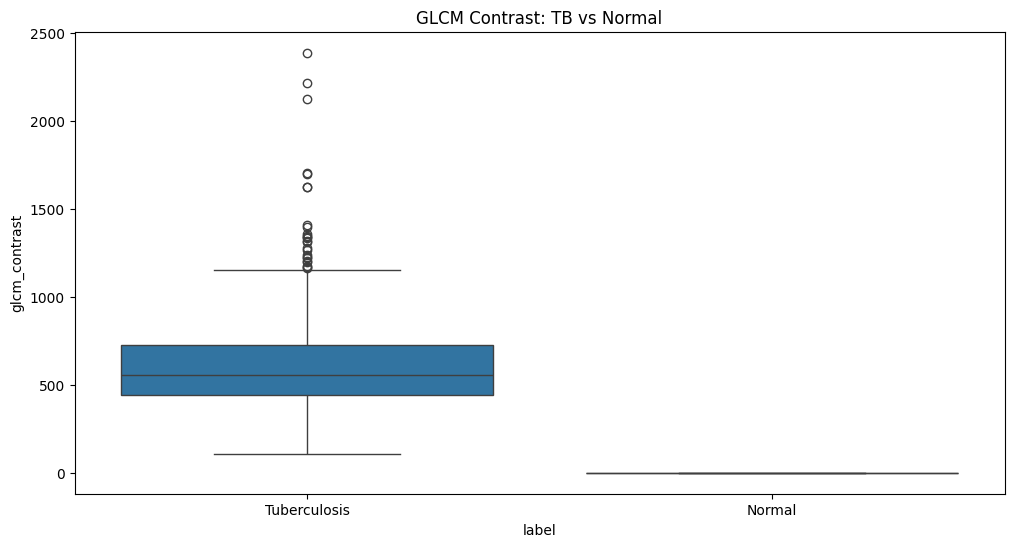

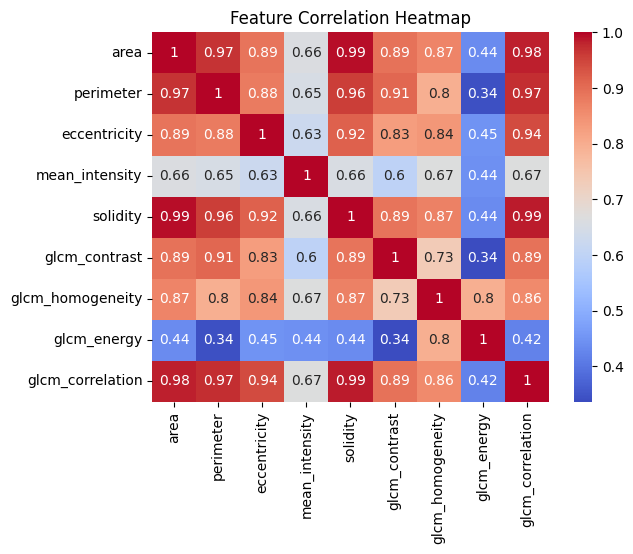

In [7]:
import seaborn as sns

# Boxplot for key features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='label', y='glcm_contrast')
plt.title("GLCM Contrast: TB vs Normal")
plt.show()

# Correlation heatmap
corr = df.drop(columns='label').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


## Conclusion

- CLAHE + Gaussian Blur preprocessing improved visibility of lung lesions.
- Otsu + morphological ops successfully isolated lung/lesion regions.
- GLCM features (e.g., contrast, correlation) were more discriminative than basic shape features.
- The dataset allows clear visual and quantitative differentiation between TB and Normal classes.

Future work: apply ML classifier (SVM/KNN) on features, or try full lung segmentation.
